1) Find Outliers (use gaussian formula with cos)

2) Classification problem with target value: Outlier/ not Outlier

3) Classification problem before and after removal of outliers



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.stats import multivariate_normal
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn import tree
from imblearn.combine import SMOTETomek
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def oneHotFunc(df, categ):
  for i in range(len(categ)):
    one_hot = pd.get_dummies(df[categ[i]])
    names = df[categ[i]].unique()
    temp = []
    for j in range(len(names)):
      temp.append(categ[i] +'_'+ str(names[j]))
    one_hot.columns = temp
    df = df.drop(categ[i],axis = 1)
    df= df.join(one_hot)
  print(df.head())
  return df

In [ ]:
def MissingValuesHandler(df, categ, cont):
  for s in categ:
    mode = df[s].mode()[0]
    df[s] = df[s].replace("?", mode)
  for s in cont:
    temp = df[s].copy()
    temp = temp.replace("?", 0)
    temp = temp.replace('nan', 0)
    median = temp.median()
    df[s] = df[s].replace('?',median)
    df[s] = df[s].replace('nan',median)
  return df

In [ ]:
def MapFunc(df, str_ar):
  for i in range(len(str_ar)):
    uni = df[str_ar[i]].unique()
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    df[str_ar[i]] = [d[item] for item in df[str_ar[i]]]
  return df

Removing Outliers
-------------------------

Cylinder Bands
---------------

In [ ]:
colnames = ['timestamp', 'cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank',
'proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content', 'target']
df = pd.read_csv("drive/MyDrive/Datasets/bands.data",names=colnames, header=None)
df = df.drop('timestamp',1)
df = df.drop('target',1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':


,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,...,ink_pct,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
0,X126,TVGUIDE,25503,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,...,50.5,36.4,0,0,2.5,1,34,40,105,100
1,X266,TVGUIDE,25503,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,...,54.9,38.5,0,0,2.5,0.7,34,40,105,100
2,B7,MODMAT,47201,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,COATED,...,53.8,39.8,0,0,2.8,0.9,40,40,103.87,100
3,T133,MASSEY,39039,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,UNCOATED,...,55.6,38.8,0,0,2.5,1.3,40,40,108.06,100
4,J34,KMART,37351,NO,KEY,YES,BENTON,GALLATIN,UNCOATED,COATED,...,57.5,42.5,5,0,2.3,0.6,35,40,106.67,100


cylinder number: nominal

customer: nominal;

job number: nominal;

grain screened: nominal; yes, no

ink color: nominal;  key, type

proof on ctd ink:  nominal;  yes, no  

blade mfg: nominal;  benton, daetwyler, uddeholm

cylinder division: nominal;  gallatin, warsaw, mattoon

paper type: nominal;  uncoated, coated, super

ink type: nominal;  uncoated, coated, cover

direct steam: nominal; use; yes, no *

solvent type: nominal;  xylol, lactol, naptha, line, other

type on cylinder:  nominal;  yes, no  

press type: nominal; use; 70 wood hoe, 70 motter, 70 albert, 94 motter

press: nominal;  821, 802, 813, 824, 815, 816, 827, 828

unit number: nominal;  1, 2, 3, 4, 5, 6, 7, 8, 9, 10

cylinder size: nominal;  catalog, spiegel, tabloid

paper mill location: nominal; north us, south us, canadian, scandanavian, mid european

plating tank: nominal; 1910, 1911, other

band type: nominal; class; band, no band *

In [ ]:
str_ar = ['cylinder_number', 'customer', 'job_number', 'ink_color', 'cylinder_division', 'paper_type', 'ink_type',
          'press_type', 'press', 'unit_number']
df = MapFunc(df, str_ar)
df.head()

,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,...,ink_pct,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
0,0,0,0,YES,0,YES,BENTON,0,0,0,...,50.5,36.4,0,0,2.5,1,34,40,105,100
1,1,0,0,YES,0,YES,BENTON,0,0,0,...,54.9,38.5,0,0,2.5,0.7,34,40,105,100
2,2,1,1,YES,0,YES,BENTON,0,0,1,...,53.8,39.8,0,0,2.8,0.9,40,40,103.87,100
3,3,2,2,YES,0,YES,BENTON,0,0,0,...,55.6,38.8,0,0,2.5,1.3,40,40,108.06,100
4,4,3,3,NO,0,YES,BENTON,0,0,1,...,57.5,42.5,5,0,2.3,0.6,35,40,106.67,100


In [ ]:
str_ar = ['grain_screened', 'proof_on_ctd_ink', 'blade_mfg', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'cylinder_size', 'paper_mill_location', 'plating_tank']
for i in range(len(str_ar)):
    uni = list(df[str_ar[i]].unique())
    uni.remove('?')
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    d['?'] = np.nan
    print(d)
    print('-------------------------')
    df[str_ar[i]] = [d[item] for item in df[str_ar[i]]]
    df[str_ar[i]] = df[str_ar[i]].replace('?',np.nan)
for i in range(len(df.columns)):
  df[df.columns[i]] = df[df.columns[i]].replace('?',np.nan)

df.head()

{'YES': 0, 'NO': 1, '?': nan}
-------------------------
{'YES': 0, 'NO': 1, '?': nan}
-------------------------
{'BENTON': 0, 'UDDEHOLM': 1, '?': nan}
-------------------------
{'NO': 0, 'YES': 1, 'no': 2, '?': nan}
-------------------------
{'LINE': 0, 'XYLOL': 1, 'NAPTHA': 2, '?': nan}
-------------------------
{'YES': 0, 'NO': 1, 'no': 2, 'yes': 3, '?': nan}
-------------------------
{'TABLOID': 0, 'CATALOG': 1, 'SPIEGEL': 2, 'catalog': 3, 'tabloid': 4, 'spiegel': 5, '?': nan}
-------------------------
{'NorthUS': 0, 'CANADIAN': 1, 'CANAdiAN': 2, 'SCANDANAVIAN': 3, 'SouthUS': 4, 'mideuropean': 5, '?': nan}
-------------------------
{'1911': 0, '1910': 1, '?': nan}
-------------------------


,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,...,ink_pct,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content
0,0,0,0,0.0,0,0.0,0.0,0,0,0,...,50.5,36.4,0,0,2.5,1,34,40,105,100
1,1,0,0,0.0,0,0.0,0.0,0,0,0,...,54.9,38.5,0,0,2.5,0.7,34,40,105,100
2,2,1,1,0.0,0,0.0,0.0,0,0,1,...,53.8,39.8,0,0,2.8,0.9,40,40,103.87,100
3,3,2,2,0.0,0,0.0,0.0,0,0,0,...,55.6,38.8,0,0,2.5,1.3,40,40,108.06,100
4,4,3,3,1.0,0,0.0,0.0,0,0,1,...,57.5,42.5,5,0,2.3,0.6,35,40,106.67,100


In [ ]:
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [ ]:
categ = ['cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank']
df = oneHotFunc(df, categ)

   proof_cut  viscosity  caliper  ink_temperature  humifity  roughness  \
0       55.0       46.0    0.200             17.0      78.0   0.750000   
1       55.0       46.0    0.300             15.0      80.0   0.750000   
2       62.0       40.0    0.433             16.0      80.0   0.833333   
3       52.0       40.0    0.300             16.0      75.0   0.312500   
4       50.0       46.0    0.300             17.0      80.0   0.750000   

   blade_pressure  varnish_pct  press_speed  ink_pct  ...  \
0            20.0         13.1       1700.0     50.5  ...   
1            20.0          6.6       1900.0     54.9  ...   
2            30.0          6.5       1850.0     53.8  ...   
3            30.0          5.6       1467.0     55.6  ...   
4            30.0          0.0       2100.0     57.5  ...   

   paper_mill_location_1.6666666666666667  \
0                                       0   
1                                       0   
2                                       0   
3       

In [ ]:
df = df.astype(float)
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
# df = df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
colnames = ['timestamp', 'cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank',
'proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content', 'target']
classify_df = pd.read_csv("drive/MyDrive/Datasets/bands.data",names=colnames, header=None)
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
colnames = ['timestamp', 'cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank',
'proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content', 'target']
original = pd.read_csv("drive/MyDrive/Datasets/bands.data",names=colnames, header=None)

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(3, 40)


In [ ]:
print(original.shape)
print(final.shape)

(540, 40)
(537, 40)


In [ ]:
final.to_csv('drive/MyDrive/Modified_Datasets/AfterRemovingOutliers/band.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Modified_Datasets/Outlier_Classification/band.csv',index=False)

Credit
---------------

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','target']
df = pd.read_csv("drive/MyDrive/Datasets/creditapproval.data",names=colnames, header=None)
df = df.drop('target', 1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0


A1:	0, 1  ('b', 'a')

A4: 0, 1, 2, 3	('u', 'y', 'l', 't')
    
A5:	0, 1, 2  ('g', 'p', 'gg')
    
A6:	0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13  ('c', 'd', 'cc', 'i', 'j', 'k', 'm', 'r', 'q', 'w', 'x', 'e', 'aa', 'ff')

A7:	0, 1, 2, 3, 4, 5, 6, 7, 8 ('v', 'h', 'bb', 'j', 'n', 'z', 'dd', 'ff', 'o')

A9:	0, 1  ('t', 'f')

A10: 0, 1  ('t', 'f')

A12:	0, 1  ('t', 'f')

A13: 0, 1, 2 ('g', 'p', 's')

target: 0, 1 ('+', '-')         (class attribute)

In [ ]:
# categ=['A1','A4','A5','A6','A7','A9','A10','A12','A13']
# cont=['A2','A3','A8','A11','A14','A15']
# df = MissingValuesHandler(df, categ, cont)

In [ ]:
str_ar = ['A9','A10','A12','A13']
df = MapFunc(df, str_ar)
str_ar = ['A1','A4','A5','A6','A7']
for i in range(len(str_ar)):
    uni = list(df[str_ar[i]].unique())
    uni.remove('?')
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    d['?'] = np.nan
    print(d)
    print('-------------------------')
    df[str_ar[i]] = [d[item] for item in df[str_ar[i]]]
    df[str_ar[i]] = df[str_ar[i]].replace('?',np.nan)

for i in range(len(df.columns)):
  df[df.columns[i]] = df[df.columns[i]].replace('?',np.nan)

df.head()

{'b': 0, 'a': 1, '?': nan}
-------------------------
{'u': 0, 'y': 1, 'l': 2, '?': nan}
-------------------------
{'g': 0, 'p': 1, 'gg': 2, '?': nan}
-------------------------
{'w': 0, 'q': 1, 'm': 2, 'r': 3, 'cc': 4, 'k': 5, 'c': 6, 'd': 7, 'x': 8, 'i': 9, 'e': 10, 'aa': 11, 'ff': 12, 'j': 13, '?': nan}
-------------------------
{'v': 0, 'h': 1, 'bb': 2, 'ff': 3, 'j': 4, 'z': 5, 'o': 6, 'dd': 7, 'n': 8, '?': nan}
-------------------------


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,0.0,30.83,0.000,0.0,0.0,0.0,0.0,1.25,0,0,1,0,0,00202,0
1,1.0,58.67,4.460,0.0,0.0,1.0,1.0,3.04,0,0,6,0,0,00043,560
2,1.0,24.50,0.500,0.0,0.0,1.0,1.0,1.50,0,1,0,0,0,00280,824
3,0.0,27.83,1.540,0.0,0.0,0.0,0.0,3.75,0,0,5,1,0,00100,3
4,0.0,20.17,5.625,0.0,0.0,0.0,0.0,1.71,0,1,0,0,1,00120,0


In [ ]:
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [ ]:
categ=['A1','A4','A5','A6','A7','A9','A10','A12','A13']
df = oneHotFunc(df, categ)

      A2     A3    A8  A11    A14    A15  A1_0.0  A1_1.0  \
0  30.83  0.000  1.25  1.0  202.0    0.0       1       0   
1  58.67  4.460  3.04  6.0   43.0  560.0       0       0   
2  24.50  0.500  1.50  0.0  280.0  824.0       0       0   
3  27.83  1.540  3.75  5.0  100.0    3.0       1       0   
4  20.17  5.625  1.71  0.0  120.0    0.0       1       0   

   A1_0.6666666666666666  A1_0.3333333333333333  ...  A7_1.6666666666666667  \
0                      0                      0  ...                      0   
1                      0                      1  ...                      0   
2                      0                      1  ...                      0   
3                      0                      0  ...                      0   
4                      0                      0  ...                      0   

   A9_0.0  A9_1.0  A10_0.0  A10_1.0  A12_0.0  A12_1.0  A13_0.0  A13_1.0  \
0       1       0        1        0        1        0        1        0   
1       1     

In [ ]:
df = df.astype(float)
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
# df = df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','target']
classify_df = pd.read_csv("drive/MyDrive/Datasets/creditapproval.data",names=colnames, header=None)
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','target']
original = pd.read_csv("drive/MyDrive/Datasets/creditapproval.data",names=colnames, header=None)

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(5, 16)


In [ ]:
print(original.shape)
print(final.shape)

(690, 16)
(685, 16)


In [ ]:
final.to_csv('drive/MyDrive/Modified_Datasets/AfterRemovingOutliers/credit.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Modified_Datasets/Outlier_Classification/credit.csv',index=False)

Australian
---------------

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','target']
df = pd.read_csv("drive/MyDrive/Datasets/australian.dat",delimiter=' ',names=colnames, header=None)
df = df.drop('target', 1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159


Categorical attributes:

A1:	0, 1   (a, b)

A4:	1, 2, 3  (p, g, gg)

A5:  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14 (ff, d, i, k, j, aa, m, c, w, e, q, r, cc, x )

A6:	 1, 2, 3, 4, 5, 6, 7, 8, 9  (ff, dd, j, bb, v, n, o, h, z)

A8:	1, 0  (t, f)

A9: 1, 0	(t, f)

A11: 1, 0 (t, f)

A12: 1, 2, 3  (s, g, p)

target: 0, 1 (+, -)  (class attribute)

In [ ]:
categ = ['A1','A4','A5','A6','A8','A9','A11','A12']
df = oneHotFunc(df, categ)

      A2     A3     A7  A10  A13   A14  A1_1  A1_0  A4_2  A4_1  ...  A6_7  \
0  22.08  11.46  1.585    0  100  1213     0     1     0     1  ...     0   
1  22.67   7.00  0.165    0  160     1     1     0     0     1  ...     0   
2  29.58   1.75  1.250    0  280     1     1     0     1     0  ...     0   
3  21.67  11.50  0.000   11    0     1     1     0     1     0  ...     0   
4  20.17   8.17  1.960   14   60   159     0     1     0     1  ...     0   

   A8_0  A8_1  A9_0  A9_1  A11_1  A11_0  A12_2  A12_1  A12_3  
0     1     0     1     0      0      1      0      1      0  
1     1     0     1     0      1      0      0      1      0  
2     1     0     1     0      0      1      0      1      0  
3     0     1     0     1      0      1      0      1      0  
4     0     1     0     1      1      0      0      1      0  

[5 rows x 42 columns]


In [ ]:
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','target']
classify_df = pd.read_csv("drive/MyDrive/Datasets/australian.dat",delimiter=' ',names=colnames, header=None)
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','target']
original = pd.read_csv("drive/MyDrive/Datasets/australian.dat",delimiter=' ',names=colnames, header=None)

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(7, 15)


In [ ]:
print(original.shape)
print(final.shape)

(690, 15)
(683, 15)


In [ ]:
final.to_csv('drive/MyDrive/Datasets/AfterRemovingOutliers/australian.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Datasets/Outlier_Classification/australian.csv',index=False)

German
---------------

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','target']
df = pd.read_csv("drive/MyDrive/Datasets/german.data",delimiter=' ',names=colnames, header=None)
df = df.drop('target', 1)
df.head

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


<bound method NDFrame.head of       A1  A2   A3   A4    A5   A6   A7  A8   A9   A10  A11   A12  A13   A14  \
0    A11   6  A34  A43  1169  A65  A75   4  A93  A101    4  A121   67  A143   
1    A12  48  A32  A43  5951  A61  A73   2  A92  A101    2  A121   22  A143   
2    A14  12  A34  A46  2096  A61  A74   2  A93  A101    3  A121   49  A143   
3    A11  42  A32  A42  7882  A61  A74   2  A93  A103    4  A122   45  A143   
4    A11  24  A33  A40  4870  A61  A73   3  A93  A101    4  A124   53  A143   
..   ...  ..  ...  ...   ...  ...  ...  ..  ...   ...  ...   ...  ...   ...   
995  A14  12  A32  A42  1736  A61  A74   3  A92  A101    4  A121   31  A143   
996  A11  30  A32  A41  3857  A61  A73   4  A91  A101    4  A122   40  A143   
997  A14  12  A32  A43   804  A61  A75   4  A93  A101    4  A123   38  A143   
998  A11  45  A32  A43  1845  A61  A73   4  A93  A101    4  A124   23  A143   
999  A12  45  A34  A41  4576  A62  A71   3  A93  A101    4  A123   27  A143   

      A15  A16   A17 

Categorical attributes:

A1: 0, 1, 2, 3 ('A11', 'A12', 'A14', 'A13')

A3:	0, 1, 2, 3, 4  ('A34', 'A32', 'A33', 'A30', 'A31')

A4: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ('A43', 'A46', 'A42', 'A40', 'A41', 'A49', 'A44', 'A45', 'A410',
       'A48')

A6:	 0, 1, 2, 3, 4  ('A65', 'A61', 'A63', 'A64', 'A62')

A7:	0, 1, 2, 3, 4  ('A75', 'A73', 'A74', 'A71', 'A72')

A9: 0, 1, 2, 3,	('A93', 'A92', 'A91', 'A94')

A10: 0, 1, 2 ('A101', 'A103', 'A102')

A12: 0, 1, 2, 3  ('A121', 'A122', 'A124', 'A123')

A14: 0, 1, 2 ('A143', 'A141', 'A142')

A15: 0, 1, 2 ('A152', 'A153', 'A151')

A17: 0, 1, 2, 3 ('A173', 'A172', 'A174', 'A171')

A19: 0, 1 ('A192', 'A191')

A20: 0, 1 ('A201', 'A202)

target: 1, 2

In [ ]:
categ=['A1','A3','A4','A6','A7','A9','A10','A12','A14','A15','A17','A19','A20']
df = oneHotFunc(df, categ)

   A2    A5  A8  A11  A13  A16  A18  A1_A11  A1_A12  A1_A14  ...  A15_A153  \
0   6  1169   4    4   67    2    1       1       0       0  ...         1   
1  48  5951   2    2   22    1    1       0       1       0  ...         1   
2  12  2096   2    3   49    1    2       0       0       0  ...         1   
3  42  7882   2    4   45    1    2       1       0       0  ...         0   
4  24  4870   3    4   53    2    2       1       0       0  ...         0   

   A15_A151  A17_A173  A17_A172  A17_A174  A17_A171  A19_A192  A19_A191  \
0         0         0         0         1         0         0         1   
1         0         0         0         1         0         1         0   
2         0         0         1         0         0         1         0   
3         1         0         0         1         0         1         0   
4         1         0         0         1         0         1         0   

   A20_A201  A20_A202  
0         1         0  
1         1         0  
2       

In [ ]:
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','target']
classify_df = pd.read_csv("drive/MyDrive/Datasets/german.data",delimiter=' ',names=colnames, header=None)
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','target']
original = pd.read_csv("drive/MyDrive/Datasets/german.data",delimiter=' ',names=colnames, header=None)

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(7, 21)


In [ ]:
print(original.shape)
print(final.shape)

(1000, 21)
(993, 21)


In [ ]:
final.to_csv('drive/MyDrive/Datasets/AfterRemovingOutliers/german.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Datasets/Outlier_Classification/german.csv',index=False)

Heart
---------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/heart.csv")
df = df.drop('target', 1)
df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


(303, 13)

Unique values for categorical variables

sex: [1, 0]

cp: [3, 2, 1, 0]

fbs: [1, 0]

restecg: [0, 1, 2]

exang: [0, 1]

slope: [0, 2, 1]

ca: [0, 2, 1, 3, 4]

thal: [1, 2, 3, 0]



In [ ]:
categ = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
df = oneHotFunc(df,categ)

   age  trestbps  chol  thalach  oldpeak  sex_1  sex_0  cp_3  cp_2  cp_1  ...  \
0   63       145   233      150      2.3      0      1     0     0     0  ...   
1   37       130   250      187      3.5      0      1     0     0     1  ...   
2   41       130   204      172      1.4      1      0     0     1     0  ...   
3   56       120   236      178      0.8      0      1     0     1     0  ...   
4   57       120   354      163      0.6      1      0     1     0     0  ...   

   slope_1  ca_0  ca_2  ca_1  ca_3  ca_4  thal_1  thal_2  thal_3  thal_0  
0        0     1     0     0     0     0       0       1       0       0  
1        0     1     0     0     0     0       0       0       1       0  
2        1     1     0     0     0     0       0       0       1       0  
3        1     1     0     0     0     0       0       0       1       0  
4        1     1     0     0     0     0       0       0       1       0  

[5 rows x 30 columns]


In [ ]:
df=(df- df.mean())/df.std()
std=df.std()
df=df.transform(lambda x:-0.5*x**2)
df.to_numpy()
df_new = np.cos(df)
df_new = df_new / (math.sqrt(2*math.pi))
df_new = df_new / std
a=df_new.to_numpy()
df_new['score'] = np.sum(a,axis = 1 )

In [ ]:
classify_df= pd.read_csv('drive/MyDrive/Datasets/heart.csv')
classify_df = classify_df.drop('target', 1)
classify_df['outlier']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
original = pd.read_csv('drive/MyDrive/Datasets/heart.csv')

In [ ]:
avg=np.mean(df_new['score'])
std=np.std(df_new['score'])
final = pd.DataFrame()
outliers = pd.DataFrame()
for i in range(df_new.shape[0]):
  if df_new['score'][i] > avg + (3*std) or df_new['score'][i] < avg - (3*std):
    outliers=outliers.append(original.iloc[i])
    classify_df['outlier'][i]=1
  else:
    final=final.append(original.iloc[i])
print(outliers.shape)

(4, 14)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
print(original.shape)
print(final.shape)

(303, 14)
(299, 14)


In [ ]:
final.to_csv('drive/MyDrive/Datasets/AfterRemovingOutliers/heart.csv', index=False)

In [ ]:
classify_df.to_csv('drive/MyDrive/Datasets/Outlier_Classification/heart.csv',index=False)

Classification Problem
--------------------------------
Given sample Outlier or not

Cylinder Bands
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Modified_Datasets/Outlier_Classification/band.csv")
df.head()

,timestamp,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,...,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,outlier
0,19910108,X126,TVGUIDE,25503,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,...,36.4,0,0,2.5,1,34,40,105,100,0
1,19910109,X266,TVGUIDE,25503,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,...,38.5,0,0,2.5,0.7,34,40,105,100,0
2,19910104,B7,MODMAT,47201,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,...,39.8,0,0,2.8,0.9,40,40,103.87,100,0
3,19910104,T133,MASSEY,39039,YES,KEY,YES,BENTON,GALLATIN,UNCOATED,...,38.8,0,0,2.5,1.3,40,40,108.06,100,0
4,19910111,J34,KMART,37351,NO,KEY,YES,BENTON,GALLATIN,UNCOATED,...,42.5,5,0,2.3,0.6,35,40,106.67,100,0


In [ ]:
str_ar = ['cylinder_number', 'customer', 'job_number', 'ink_color', 'cylinder_division', 'paper_type', 'ink_type',
          'press_type', 'press', 'unit_number']
df = MapFunc(df, str_ar)
df = df.drop('timestamp',1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,...,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,outlier
0,0,0,0,YES,0,YES,BENTON,0,0,0,...,36.4,0,0,2.5,1,34,40,105,100,0
1,1,0,0,YES,0,YES,BENTON,0,0,0,...,38.5,0,0,2.5,0.7,34,40,105,100,0
2,2,1,1,YES,0,YES,BENTON,0,0,1,...,39.8,0,0,2.8,0.9,40,40,103.87,100,0
3,3,2,2,YES,0,YES,BENTON,0,0,0,...,38.8,0,0,2.5,1.3,40,40,108.06,100,0
4,4,3,3,NO,0,YES,BENTON,0,0,1,...,42.5,5,0,2.3,0.6,35,40,106.67,100,0


In [ ]:
str_ar = ['grain_screened', 'proof_on_ctd_ink', 'blade_mfg', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'cylinder_size', 'paper_mill_location', 'plating_tank']
for i in range(len(str_ar)):
    uni = list(df[str_ar[i]].unique())
    uni.remove('?')
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    d['?'] = np.nan
    print(d)
    print('-------------------------')
    df[str_ar[i]] = [d[item] for item in df[str_ar[i]]]
    df[str_ar[i]] = df[str_ar[i]].replace('?',np.nan)
for i in range(len(df.columns)):
  df[df.columns[i]] = df[df.columns[i]].replace('?',np.nan)

df.head()

{'YES': 0, 'NO': 1, '?': nan}
-------------------------
{'YES': 0, 'NO': 1, '?': nan}
-------------------------
{'BENTON': 0, 'UDDEHOLM': 1, '?': nan}
-------------------------
{'NO': 0, 'YES': 1, 'no': 2, '?': nan}
-------------------------
{'LINE': 0, 'XYLOL': 1, 'NAPTHA': 2, '?': nan}
-------------------------
{'YES': 0, 'NO': 1, 'no': 2, 'yes': 3, '?': nan}
-------------------------
{'TABLOID': 0, 'CATALOG': 1, 'SPIEGEL': 2, 'catalog': 3, 'tabloid': 4, 'spiegel': 5, '?': nan}
-------------------------
{'NorthUS': 0, 'CANADIAN': 1, 'CANAdiAN': 2, 'SCANDANAVIAN': 3, 'SouthUS': 4, 'mideuropean': 5, '?': nan}
-------------------------
{'1911': 0, '1910': 1, '?': nan}
-------------------------


,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,...,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,outlier
0,0,0,0,0.0,0,0.0,0.0,0,0,0,...,36.4,0,0,2.5,1,34,40,105,100,0
1,1,0,0,0.0,0,0.0,0.0,0,0,0,...,38.5,0,0,2.5,0.7,34,40,105,100,0
2,2,1,1,0.0,0,0.0,0.0,0,0,1,...,39.8,0,0,2.8,0.9,40,40,103.87,100,0
3,3,2,2,0.0,0,0.0,0.0,0,0,0,...,38.8,0,0,2.5,1.3,40,40,108.06,100,0
4,4,3,3,1.0,0,0.0,0.0,0,0,1,...,42.5,5,0,2.3,0.6,35,40,106.67,100,0


In [ ]:
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [ ]:
categ = ['cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank']
df = oneHotFunc(df, categ)
df = df.astype(float)

   proof_cut  viscosity  caliper  ink_temperature  humifity  roughness  \
0       55.0       46.0    0.200             17.0      78.0   0.750000   
1       55.0       46.0    0.300             15.0      80.0   0.750000   
2       62.0       40.0    0.433             16.0      80.0   0.833333   
3       52.0       40.0    0.300             16.0      75.0   0.312500   
4       50.0       46.0    0.300             17.0      80.0   0.750000   

   blade_pressure  varnish_pct  press_speed  ink_pct  ...  \
0            20.0         13.1       1700.0     50.5  ...   
1            20.0          6.6       1900.0     54.9  ...   
2            30.0          6.5       1850.0     53.8  ...   
3            30.0          5.6       1467.0     55.6  ...   
4            30.0          0.0       2100.0     57.5  ...   

   paper_mill_location_1.6666666666666667  \
0                                       0   
1                                       0   
2                                       0   
3       

In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0.0    537
1.0    537
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


Confusion Matrix:
[[156   1]
 [  0 166]]
Accuracy: 0.9969040247678018
Precision: 0.9940119760479041
Recall: 1.0
TPR:  1.0
FPR:  0.006369426751592357
F1 Score: 0.996996996996997


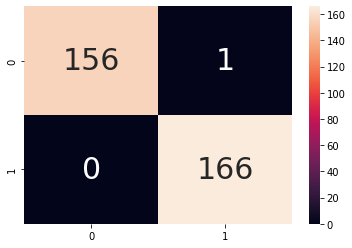

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[156   1]
 [  0 166]]
Accuracy: 0.9969040247678018
Precision: 0.9940119760479041
Recall: 1.0
TPR:  1.0
FPR:  0.006369426751592357
F1 Score: 0.996996996996997


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[155   2]
 [  0 166]]
Accuracy: 0.9938080495356038
Precision: 0.9880952380952381
Recall: 1.0
TPR:  1.0
FPR:  0.012738853503184714
F1 Score: 0.9940119760479043


Credit
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Modified_Datasets/Outlier_Classification/credit.csv")
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,outlier
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,0
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,0
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,0
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,0
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,0


In [ ]:
str_ar = ['A9','A10','A12','A13']
df = MapFunc(df, str_ar)
str_ar = ['A1','A4','A5','A6','A7']
for i in range(len(str_ar)):
    uni = list(df[str_ar[i]].unique())
    uni.remove('?')
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    d['?'] = np.nan
    print(d)
    print('-------------------------')
    df[str_ar[i]] = [d[item] for item in df[str_ar[i]]]
    df[str_ar[i]] = df[str_ar[i]].replace('?',np.nan)

for i in range(len(df.columns)):
  df[df.columns[i]] = df[df.columns[i]].replace('?',np.nan)

df.head()

{'b': 0, 'a': 1, '?': nan}
-------------------------
{'u': 0, 'y': 1, 'l': 2, '?': nan}
-------------------------
{'g': 0, 'p': 1, 'gg': 2, '?': nan}
-------------------------
{'w': 0, 'q': 1, 'm': 2, 'r': 3, 'cc': 4, 'k': 5, 'c': 6, 'd': 7, 'x': 8, 'i': 9, 'e': 10, 'aa': 11, 'ff': 12, 'j': 13, '?': nan}
-------------------------
{'v': 0, 'h': 1, 'bb': 2, 'ff': 3, 'j': 4, 'z': 5, 'o': 6, 'dd': 7, 'n': 8, '?': nan}
-------------------------


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,outlier
0,0.0,30.83,0.000,0.0,0.0,0.0,0.0,1.25,0,0,1,0,0,00202,0,0
1,1.0,58.67,4.460,0.0,0.0,1.0,1.0,3.04,0,0,6,0,0,00043,560,0
2,1.0,24.50,0.500,0.0,0.0,1.0,1.0,1.50,0,1,0,0,0,00280,824,0
3,0.0,27.83,1.540,0.0,0.0,0.0,0.0,3.75,0,0,5,1,0,00100,3,0
4,0.0,20.17,5.625,0.0,0.0,0.0,0.0,1.71,0,1,0,0,1,00120,0,0


In [ ]:
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [ ]:
categ=['A1','A4','A5','A6','A7','A9','A10','A12','A13']
df = oneHotFunc(df,categ)
df = df.astype(float)

      A2     A3    A8  A11    A14    A15  outlier  A1_0.0  A1_1.0  \
0  30.83  0.000  1.25  1.0  202.0    0.0      0.0       1       0   
1  58.67  4.460  3.04  6.0   43.0  560.0      0.0       0       0   
2  24.50  0.500  1.50  0.0  280.0  824.0      0.0       0       0   
3  27.83  1.540  3.75  5.0  100.0    3.0      0.0       1       0   
4  20.17  5.625  1.71  0.0  120.0    0.0      0.0       1       0   

   A1_0.6666666666666666  ...  A7_1.6666666666666667  A9_0.0  A9_1.0  A10_0.0  \
0                      0  ...                      0       1       0        1   
1                      0  ...                      0       1       0        1   
2                      0  ...                      0       1       0        0   
3                      0  ...                      0       1       0        1   
4                      0  ...                      0       1       0        0   

   A10_1.0  A12_0.0  A12_1.0  A13_0.0  A13_1.0  A13_2.0  
0        0        1        0        1   

In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0.0    685
1.0    685
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


Confusion Matrix:
[[213   1]
 [  0 197]]
Accuracy: 0.9975669099756691
Precision: 0.9949494949494949
Recall: 1.0
TPR:  1.0
FPR:  0.004672897196261682
F1 Score: 0.9974683544303797


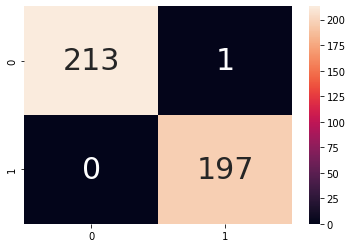

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d",annot_kws={'size': 30})
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[213   1]
 [  0 197]]
Accuracy: 0.9975669099756691
Precision: 0.9949494949494949
Recall: 1.0
TPR:  1.0
FPR:  0.004672897196261682
F1 Score: 0.9974683544303797


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[213   1]
 [  0 197]]
Accuracy: 0.9975669099756691
Precision: 0.9949494949494949
Recall: 1.0
TPR:  1.0
FPR:  0.004672897196261682
F1 Score: 0.9974683544303797


Australian
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/Outlier_Classification/australian.csv")
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,outlier
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,0


In [ ]:
categ = ['A1','A4','A5','A6','A8','A9','A11','A12']
df = oneHotFunc(df, categ)

      A2     A3     A7  A10  A13   A14  outlier  A1_1  A1_0  A4_2  ...  A6_7  \
0  22.08  11.46  1.585    0  100  1213        0     0     1     0  ...     0   
1  22.67   7.00  0.165    0  160     1        0     1     0     0  ...     0   
2  29.58   1.75  1.250    0  280     1        0     1     0     1  ...     0   
3  21.67  11.50  0.000   11    0     1        0     1     0     1  ...     0   
4  20.17   8.17  1.960   14   60   159        0     0     1     0  ...     0   

   A8_0  A8_1  A9_0  A9_1  A11_1  A11_0  A12_2  A12_1  A12_3  
0     1     0     1     0      0      1      0      1      0  
1     1     0     1     0      1      0      0      1      0  
2     1     0     1     0      0      1      0      1      0  
3     0     1     0     1      0      1      0      1      0  
4     0     1     0     1      1      0      0      1      0  

[5 rows x 43 columns]


In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0    683
1    683
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[207   6]
 [  0 197]]
Accuracy: 0.9853658536585366
Precision: 0.9704433497536946
Recall: 1.0
TPR:  1.0
FPR:  0.028169014084507043
F1 Score: 0.985


In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[212   1]
 [  0 197]]
Accuracy: 0.9975609756097561
Precision: 0.9949494949494949
Recall: 1.0
TPR:  1.0
FPR:  0.004694835680751174
F1 Score: 0.9974683544303797


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[212   1]
 [  0 197]]
Accuracy: 0.9975609756097561
Precision: 0.9949494949494949
Recall: 1.0
TPR:  1.0
FPR:  0.004694835680751174
F1 Score: 0.9974683544303797


German
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/Outlier_Classification/german.csv")
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A12,A13,A14,A15,A16,A17,A18,A19,A20,outlier
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [ ]:
categ=['A1','A3','A4','A6','A7','A9','A10','A12','A14','A15','A17','A19','A20']
df = oneHotFunc(df, categ)

   A2    A5  A8  A11  A13  A16  A18  outlier  A1_A11  A1_A12  ...  A15_A153  \
0   6  1169   4    4   67    2    1        0       1       0  ...         1   
1  48  5951   2    2   22    1    1        0       0       1  ...         1   
2  12  2096   2    3   49    1    2        0       0       0  ...         1   
3  42  7882   2    4   45    1    2        0       1       0  ...         0   
4  24  4870   3    4   53    2    2        0       1       0  ...         0   

   A15_A151  A17_A173  A17_A172  A17_A174  A17_A171  A19_A192  A19_A191  \
0         0         0         0         1         0         0         1   
1         0         0         0         1         0         1         0   
2         0         0         1         0         0         1         0   
3         1         0         0         1         0         1         0   
4         1         0         0         1         0         1         0   

   A20_A201  A20_A202  
0         1         0  
1         1         0  
2 

In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0    993
1    993
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[295   1]
 [  0 300]]
Accuracy: 0.9983221476510067
Precision: 0.9966777408637874
Recall: 1.0
TPR:  1.0
FPR:  0.0033783783783783786
F1 Score: 0.9983361064891847


In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[294   2]
 [  0 300]]
Accuracy: 0.9966442953020134
Precision: 0.9933774834437086
Recall: 1.0
TPR:  1.0
FPR:  0.006756756756756757
F1 Score: 0.9966777408637874


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[294   2]
 [  0 300]]
Accuracy: 0.9966442953020134
Precision: 0.9933774834437086
Recall: 1.0
TPR:  1.0
FPR:  0.006756756756756757
F1 Score: 0.9966777408637874


Heart
--------------

In [ ]:
df=pd.read_csv("drive/MyDrive/Datasets/Outlier_Classification/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,outlier
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


In [ ]:
categ = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
df = oneHotFunc(df, categ)

   age  trestbps  chol  thalach  oldpeak  outlier  sex_1  sex_0  cp_3  cp_2  \
0   63       145   233      150      2.3        0      0      1     0     0   
1   37       130   250      187      3.5        0      0      1     0     0   
2   41       130   204      172      1.4        0      1      0     0     1   
3   56       120   236      178      0.8        0      0      1     0     1   
4   57       120   354      163      0.6        0      1      0     1     0   

   ...  slope_1  ca_0  ca_2  ca_1  ca_3  ca_4  thal_1  thal_2  thal_3  thal_0  
0  ...        0     1     0     0     0     0       0       1       0       0  
1  ...        0     1     0     0     0     0       0       0       1       0  
2  ...        1     1     0     0     0     0       0       0       1       0  
3  ...        1     1     0     0     0     0       0       0       1       0  
4  ...        1     1     0     0     0     0       0       0       1       0  

[5 rows x 31 columns]


In [ ]:
msk = df['outlier'] == 1
num_to_oversample = len(df) - 2*msk.sum()
df_positive_oversample = df[msk].sample(n=num_to_oversample, replace=True, random_state=888)
df_train_oversample = pd.concat([df, df_positive_oversample])
df_train_oversample['outlier'].value_counts()

0    299
1    299
Name: outlier, dtype: int64

In [ ]:
X_train, X_test = train_test_split(df_train_oversample, test_size = 0.3, random_state = 0)
y_train = X_train['outlier']
X_train = X_train.drop('outlier',1)
y_test = X_test['outlier']
X_test = X_test.drop('outlier',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[87  0]
 [ 0 93]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
TPR:  1.0
FPR:  0.0
F1 Score: 1.0


In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, y_train)
y_pred = svc_model .predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[87  0]
 [ 0 93]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
TPR:  1.0
FPR:  0.0
F1 Score: 1.0


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Confusion Matrix:
[[87  0]
 [ 0 93]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
TPR:  1.0
FPR:  0.0
F1 Score: 1.0


Classification
-----------------------------
Before and after removing Outliers: using Random Forest

Cylinder Bands
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Modified_Datasets/AfterRemovingOutliers/band.csv")
colnames = ['timestamp', 'cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank',
'proof_cut', 'viscosity', 'caliper', 'ink_temperature', 'humifity', 'roughness', 'blade_pressure', 'varnish_pct',
'press_speed', 'ink_pct', 'solvent_pct', 'ESA_Voltage', 'ESA_Amperage', 'wax', 'hardener', 'roller_durometer',
'current_density', 'anode_space_ratio', 'chrome_content', 'target']
df_before = pd.read_csv("drive/MyDrive/Datasets/bands.data",names=colnames, header=None)

In [ ]:
str_ar = ['cylinder_number', 'customer', 'job_number', 'ink_color', 'cylinder_division', 'paper_type', 'ink_type',
          'press_type', 'press', 'unit_number','target']
df_before = MapFunc(df_before, str_ar)
df_before = df_before.drop('timestamp',1)
df_after = MapFunc(df_after, str_ar)
df_after = df_after.drop('timestamp',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
str_ar = ['grain_screened', 'proof_on_ctd_ink', 'blade_mfg', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'cylinder_size', 'paper_mill_location', 'plating_tank']
for i in range(len(str_ar)):
    uni = list(df_before[str_ar[i]].unique())
    uni.remove('?')
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    d['?'] = np.nan
    print(d)
    print('-------------------------')
    df_before[str_ar[i]] = [d[item] for item in df_before[str_ar[i]]]
    df_before[str_ar[i]] = df_before[str_ar[i]].replace('?',np.nan)
for i in range(len(df_before.columns)):
  df_before[df_before.columns[i]] = df_before[df_before.columns[i]].replace('?',np.nan)

df_before.head()

{'YES': 0, 'NO': 1, '?': nan}
-------------------------
{'YES': 0, 'NO': 1, '?': nan}
-------------------------
{'BENTON': 0, 'UDDEHOLM': 1, '?': nan}
-------------------------
{'NO': 0, 'YES': 1, 'no': 2, '?': nan}
-------------------------
{'LINE': 0, 'XYLOL': 1, 'NAPTHA': 2, '?': nan}
-------------------------
{'YES': 0, 'NO': 1, 'no': 2, 'yes': 3, '?': nan}
-------------------------
{'TABLOID': 0, 'CATALOG': 1, 'SPIEGEL': 2, 'catalog': 3, 'tabloid': 4, 'spiegel': 5, '?': nan}
-------------------------
{'NorthUS': 0, 'CANADIAN': 1, 'CANAdiAN': 2, 'SCANDANAVIAN': 3, 'SouthUS': 4, 'mideuropean': 5, '?': nan}
-------------------------
{'1911': 0, '1910': 1, '?': nan}
-------------------------


,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,...,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,target
0,0,0,0,0.0,0,0.0,0.0,0,0,0,...,36.4,0,0,2.5,1,34,40,105,100,0
1,1,0,0,0.0,0,0.0,0.0,0,0,0,...,38.5,0,0,2.5,0.7,34,40,105,100,1
2,2,1,1,0.0,0,0.0,0.0,0,0,1,...,39.8,0,0,2.8,0.9,40,40,103.87,100,1
3,3,2,2,0.0,0,0.0,0.0,0,0,0,...,38.8,0,0,2.5,1.3,40,40,108.06,100,1
4,4,3,3,1.0,0,0.0,0.0,0,0,1,...,42.5,5,0,2.3,0.6,35,40,106.67,100,1


In [ ]:
str_ar = ['grain_screened', 'proof_on_ctd_ink', 'blade_mfg', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'cylinder_size', 'paper_mill_location', 'plating_tank']
for i in range(len(str_ar)):
    uni = list(df_after[str_ar[i]].unique())
    uni.remove('?')
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    d['?'] = np.nan
    print(d)
    print('-------------------------')
    df_after[str_ar[i]] = [d[item] for item in df_after[str_ar[i]]]
    df_after[str_ar[i]] = df_after[str_ar[i]].replace('?',np.nan)
for i in range(len(df_after.columns)):
  df_after[df_after.columns[i]] = df_after[df_after.columns[i]].replace('?',np.nan)

df_after.head()

{'YES': 0, 'NO': 1, '?': nan}
-------------------------
{'YES': 0, 'NO': 1, '?': nan}
-------------------------
{'BENTON': 0, 'UDDEHOLM': 1, '?': nan}
-------------------------
{'NO': 0, 'YES': 1, 'no': 2, '?': nan}
-------------------------
{'LINE': 0, 'XYLOL': 1, 'NAPTHA': 2, '?': nan}
-------------------------
{'YES': 0, 'NO': 1, 'no': 2, 'yes': 3, '?': nan}
-------------------------
{'TABLOID': 0, 'CATALOG': 1, 'SPIEGEL': 2, 'catalog': 3, 'tabloid': 4, 'spiegel': 5, '?': nan}
-------------------------
{'NorthUS': 0, 'CANADIAN': 1, 'CANAdiAN': 2, 'SCANDANAVIAN': 3, 'SouthUS': 4, 'mideuropean': 5, '?': nan}
-------------------------
{'1911': 0, '1910': 1, '?': nan}
-------------------------


,cylinder_number,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,...,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,target
0,0,0,0,0.0,0,0.0,0.0,0,0,0,...,36.4,0,0,2.5,1,34,40,105,100,0
1,1,0,0,0.0,0,0.0,0.0,0,0,0,...,38.5,0,0,2.5,0.7,34,40,105,100,1
2,2,1,1,0.0,0,0.0,0.0,0,0,1,...,39.8,0,0,2.8,0.9,40,40,103.87,100,1
3,3,2,2,0.0,0,0.0,0.0,0,0,0,...,38.8,0,0,2.5,1.3,40,40,108.06,100,1
4,4,3,3,1.0,0,0.0,0.0,0,0,1,...,42.5,5,0,2.3,0.6,35,40,106.67,100,1


In [ ]:
df_before = df_before.astype(float)
df_after = df_after.astype(float)
imputer = KNNImputer(n_neighbors=3)
df_before = pd.DataFrame(imputer.fit_transform(df_before),columns = df_before.columns)
imputer = KNNImputer(n_neighbors=3)
df_after = pd.DataFrame(imputer.fit_transform(df_after),columns = df_after.columns)

In [ ]:
categ = ['cylinder_number', 'customer', 'job_number', 'grain_screened', 'ink_color',
'proof_on_ctd_ink', 'blade_mfg', 'cylinder_division', 'paper_type', 'ink_type', 'direct_steam', 'solvent_type',
'type_on_cylinder', 'press_type', 'press', 'unit_number', 'cylinder_size', 'paper_mill_location', 'plating_tank']
df_before = oneHotFunc(df_before, categ)
df_after = oneHotFunc(df_after, categ)

   proof_cut  viscosity  caliper  ink_temperature  humifity  roughness  \
0       55.0       46.0    0.200             17.0      78.0   0.750000   
1       55.0       46.0    0.300             15.0      80.0   0.750000   
2       62.0       40.0    0.433             16.0      80.0   0.833333   
3       52.0       40.0    0.300             16.0      75.0   0.312500   
4       50.0       46.0    0.300             17.0      80.0   0.750000   

   blade_pressure  varnish_pct  press_speed  ink_pct  ...  \
0            20.0         13.1       1700.0     50.5  ...   
1            20.0          6.6       1900.0     54.9  ...   
2            30.0          6.5       1850.0     53.8  ...   
3            30.0          5.6       1467.0     55.6  ...   
4            30.0          0.0       2100.0     57.5  ...   

   paper_mill_location_1.6666666666666667  \
0                                       0   
1                                       0   
2                                       0   
3       

In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=25)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[44 23]
 [12 83]]
Accuracy: 0.7839506172839507
Precision: 0.7830188679245284
Recall: 0.8736842105263158
TPR:  0.8736842105263158
FPR:  0.34328358208955223
F1 Score: 0.8258706467661692


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=15)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[47 25]
 [ 7 83]]
Accuracy: 0.8024691358024691
Precision: 0.7685185185185185
Recall: 0.9222222222222223
TPR:  0.9222222222222223
FPR:  0.3472222222222222
F1 Score: 0.8383838383838385


Credit
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Modified_Datasets/AfterRemovingOutliers/credit.csv")
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','target']
df_before = pd.read_csv("drive/MyDrive/Datasets/creditapproval.data",names=colnames, header=None)

In [ ]:
str_ar = ['A9','A10','A12','A13', 'target']
df_before = MapFunc(df_before, str_ar)
str_ar = ['A1','A4','A5','A6','A7']
for i in range(len(str_ar)):
    uni = list(df_before[str_ar[i]].unique())
    uni.remove('?')
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    d['?'] = np.nan
    print(d)
    print('-------------------------')
    df_before[str_ar[i]] = [d[item] for item in df_before[str_ar[i]]]
    df_before[str_ar[i]] = df_before[str_ar[i]].replace('?',np.nan)

for i in range(len(df_before.columns)):
  df_before[df_before.columns[i]] = df_before[df_before.columns[i]].replace('?',np.nan)

imputer = KNNImputer(n_neighbors=3)
df_before = pd.DataFrame(imputer.fit_transform(df_before),columns = df_before.columns)

{'b': 0, 'a': 1, '?': nan}
-------------------------
{'u': 0, 'y': 1, 'l': 2, '?': nan}
-------------------------
{'g': 0, 'p': 1, 'gg': 2, '?': nan}
-------------------------
{'w': 0, 'q': 1, 'm': 2, 'r': 3, 'cc': 4, 'k': 5, 'c': 6, 'd': 7, 'x': 8, 'i': 9, 'e': 10, 'aa': 11, 'ff': 12, 'j': 13, '?': nan}
-------------------------
{'v': 0, 'h': 1, 'bb': 2, 'ff': 3, 'j': 4, 'z': 5, 'o': 6, 'dd': 7, 'n': 8, '?': nan}
-------------------------


In [ ]:
str_ar = ['A9','A10','A12','A13', 'target']
df_after = MapFunc(df_after, str_ar)
str_ar = ['A1','A4','A5','A6','A7']
for i in range(len(str_ar)):
    uni = list(df_after[str_ar[i]].unique())
    uni.remove('?')
    mylist = range(0,len(uni))
    d = dict(zip(uni,mylist))
    d['?'] = np.nan
    print(d)
    print('-------------------------')
    df_after[str_ar[i]] = [d[item] for item in df_after[str_ar[i]]]
    df_after[str_ar[i]] = df_after[str_ar[i]].replace('?',np.nan)

for i in range(len(df_after.columns)):
  df_after[df_after.columns[i]] = df_after[df_after.columns[i]].replace('?',np.nan)

df_after.head()
imputer = KNNImputer(n_neighbors=3)
df_after = pd.DataFrame(imputer.fit_transform(df_after),columns = df_after.columns)

{'b': 0, 'a': 1, '?': nan}
-------------------------
{'u': 0, 'y': 1, '?': nan}
-------------------------
{'g': 0, 'p': 1, '?': nan}
-------------------------
{'w': 0, 'q': 1, 'm': 2, 'r': 3, 'cc': 4, 'k': 5, 'c': 6, 'd': 7, 'x': 8, 'i': 9, 'e': 10, 'aa': 11, 'ff': 12, 'j': 13, '?': nan}
-------------------------
{'v': 0, 'h': 1, 'bb': 2, 'ff': 3, 'j': 4, 'z': 5, 'o': 6, 'dd': 7, 'n': 8, '?': nan}
-------------------------


In [ ]:
categ=['A1','A4','A5','A6','A7','A9','A10','A12','A13']
df_before = oneHotFunc(df_before, categ)
df_after = oneHotFunc(df_after, categ)

      A2     A3    A8  A11    A14    A15  target  A1_0.0  A1_1.0  \
0  30.83  0.000  1.25  1.0  202.0    0.0     0.0       1       0   
1  58.67  4.460  3.04  6.0   43.0  560.0     0.0       0       0   
2  24.50  0.500  1.50  0.0  280.0  824.0     0.0       0       0   
3  27.83  1.540  3.75  5.0  100.0    3.0     0.0       1       0   
4  20.17  5.625  1.71  0.0  120.0    0.0     0.0       1       0   

   A1_0.6666666666666666  ...  A7_1.6666666666666667  A9_0.0  A9_1.0  A10_0.0  \
0                      0  ...                      0       1       0        1   
1                      0  ...                      0       1       0        1   
2                      0  ...                      0       1       0        0   
3                      0  ...                      0       1       0        1   
4                      0  ...                      0       1       0        0   

   A10_1.0  A12_0.0  A12_1.0  A13_0.0  A13_1.0  A13_2.0  
0        0        1        0        1        0

In [ ]:
df_before = df_before.astype(float)
df_after = df_after.astype(float)

In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[76 14]
 [18 99]]
Accuracy: 0.8454106280193237
Precision: 0.8761061946902655
Recall: 0.8461538461538461
TPR:  0.8461538461538461
FPR:  0.15555555555555556
F1 Score: 0.8608695652173913


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[ 78  10]
 [ 15 103]]
Accuracy: 0.8786407766990292
Precision: 0.911504424778761
Recall: 0.8728813559322034
TPR:  0.8728813559322034
FPR:  0.11363636363636363
F1 Score: 0.8917748917748918


Australian
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Datasets/AfterRemovingOutliers/australian.csv")
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','target']
df_before = pd.read_csv("drive/MyDrive/Datasets/australian.dat",delimiter=' ',names=colnames, header=None)

In [ ]:
categ = ['A1','A4','A5','A6','A8','A9','A11','A12']
df_after = oneHotFunc(df_after, categ)
df_before = oneHotFunc(df_before, categ)

      A2     A3     A7   A10    A13     A14  target  A1_1.0  A1_0.0  A4_2.0  \
0  22.08  11.46  1.585   0.0  100.0  1213.0     0.0       0       1       0   
1  22.67   7.00  0.165   0.0  160.0     1.0     0.0       1       0       0   
2  29.58   1.75  1.250   0.0  280.0     1.0     0.0       1       0       1   
3  21.67  11.50  0.000  11.0    0.0     1.0     1.0       1       0       1   
4  20.17   8.17  1.960  14.0   60.0   159.0     1.0       0       1       0   

   ...  A6_7.0  A8_0.0  A8_1.0  A9_0.0  A9_1.0  A11_1.0  A11_0.0  A12_2.0  \
0  ...       0       1       0       1       0        0        1        0   
1  ...       0       1       0       1       0        1        0        0   
2  ...       0       1       0       1       0        0        1        0   
3  ...       0       0       1       0       1        0        1        0   
4  ...       0       0       1       0       1        1        0        0   

   A12_1.0  A12_3.0  
0        1        0  
1        1        

In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=50)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[103  17]
 [ 18  69]]
Accuracy: 0.8309178743961353
Precision: 0.8023255813953488
Recall: 0.7931034482758621
TPR:  0.7931034482758621
FPR:  0.14166666666666666
F1 Score: 0.7976878612716762


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=50)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[106  13]
 [ 12  74]]
Accuracy: 0.8780487804878049
Precision: 0.8505747126436781
Recall: 0.8604651162790697
TPR:  0.8604651162790697
FPR:  0.1092436974789916
F1 Score: 0.8554913294797688


German
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Datasets/AfterRemovingOutliers/german.csv")
colnames = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','target']
df_before = pd.read_csv("drive/MyDrive/Datasets/german.data",delimiter=' ',names=colnames, header=None)

In [ ]:
categ=['A1','A3','A4','A6','A7','A9','A10','A12','A14','A15','A17','A19','A20']
df_before = oneHotFunc(df_before, categ)
df_after = oneHotFunc(df_after, categ)

   A2    A5  A8  A11  A13  A16  A18  target  A1_A11  A1_A12  ...  A15_A153  \
0   6  1169   4    4   67    2    1       1       1       0  ...         1   
1  48  5951   2    2   22    1    1       2       0       1  ...         1   
2  12  2096   2    3   49    1    2       1       0       0  ...         1   
3  42  7882   2    4   45    1    2       1       1       0  ...         0   
4  24  4870   3    4   53    2    2       2       1       0  ...         0   

   A15_A151  A17_A173  A17_A172  A17_A174  A17_A171  A19_A192  A19_A191  \
0         0         0         0         1         0         0         1   
1         0         0         0         1         0         1         0   
2         0         0         1         0         0         1         0   
3         1         0         0         1         0         1         0   
4         1         0         0         1         0         1         0   

   A20_A201  A20_A202  
0         1         0  
1         1         0  
2       

In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=10)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[189  14]
 [ 64  33]]
Accuracy: 0.74
Precision: 0.7470355731225297
Recall: 0.9310344827586207
TPR:  0.3402061855670103
FPR:  0.06896551724137931
F1 Score: 0.8289473684210527


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[201  14]
 [ 57  26]]
Accuracy: 0.761744966442953
Precision: 0.7790697674418605
Recall: 0.9348837209302325
TPR:  0.3132530120481928
FPR:  0.06511627906976744
F1 Score: 0.849894291754757


Heart
-------------

In [ ]:
df_after=pd.read_csv("drive/MyDrive/Datasets/AfterRemovingOutliers/heart.csv")
df_before=pd.read_csv("drive/MyDrive/Datasets/heart.csv")

In [ ]:
categ = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
df_after = oneHotFunc(df_after, categ)
df_before = oneHotFunc(df_before, categ)

    age  trestbps   chol  thalach  oldpeak  target  sex_1.0  sex_0.0  cp_3.0  \
0  63.0     145.0  233.0    150.0      2.3     1.0        0        1       0   
1  37.0     130.0  250.0    187.0      3.5     1.0        0        1       0   
2  41.0     130.0  204.0    172.0      1.4     1.0        1        0       0   
3  56.0     120.0  236.0    178.0      0.8     1.0        0        1       0   
4  57.0     120.0  354.0    163.0      0.6     1.0        1        0       1   

   cp_2.0  ...  slope_1.0  ca_0.0  ca_2.0  ca_1.0  ca_3.0  ca_4.0  thal_1.0  \
0       0  ...          0       1       0       0       0       0         0   
1       0  ...          0       1       0       0       0       0         0   
2       1  ...          1       1       0       0       0       0         0   
3       1  ...          1       1       0       0       0       0         0   
4       0  ...          1       1       0       0       0       0         0   

   thal_2.0  thal_3.0  thal_0.0  
0         

In [ ]:
X = df_before.drop('target',1)
y = df_before['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=50)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("TPR: ",tp/(tp+fn))
print("FPR: ",fp/(tn+fp))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[30  9]
 [ 9 43]]
Accuracy: 0.8021978021978022
Precision: 0.8269230769230769
Recall: 0.8269230769230769
TPR:  0.8269230769230769
FPR:  0.23076923076923078
F1 Score: 0.8269230769230769


In [ ]:
X = df_after.drop('target',1)
y = df_after['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=25)
clf=RandomForestClassifier(n_estimators=100,random_state=20)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy after removal:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Confusion Matrix:
[[32  6]
 [ 7 45]]
Accuracy after removal: 0.8555555555555555
Precision: 0.8823529411764706
Recall: 0.8653846153846154
F1 Score: 0.8737864077669903
